# Hypothesis 2: Refined Analysis (Popularity vs Frequency)

## Goal
We are re-evaluating the impact of Leader Quality on user retention by refining our metrics.
Previously, we found `Frequency` overlapped with `Consistency`. We are replacing it with **`Popularity`** (Average Class Size) to capture the social dimension of leadership.

### The 3 Metrics:
1. **Consistency (StdDev):** Reliability of schedule.
2. **Tenure (Days):** Experience level.
3. **Popularity (Avg Class Size):** Social proof / Charisma.


In [29]:
!pip install scikit-learn umap-learn


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
from sklearn.preprocessing import StandardScaler
try:
    import umap
    if not hasattr(umap, 'UMAP'):
        import umap.umap_ as umap
except ImportError:
    print("Warning: UMAP not installed. Run 'pip install umap-learn'")

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from data_loader import FitFamDataLoader

## 1. Load & Filter Data

In [31]:
loader = FitFamDataLoader(data_dir=os.path.abspath(os.path.join('..', 'fitfam-json')))
df = loader.get_unified_data()

# Filter Post-2023
df['start_time'] = pd.to_datetime(df['start_time'])
df = df[df['start_time'] >= '2023-01-01'].copy()
print(f"Loaded {len(df)} records (Post-2023).")

Loaded 94838 records (Post-2023).


## 2. Calculate Refined Leader Metrics

In [32]:
# 1. Calculate Event Sizes (Popularity Basis)
event_counts = df.groupby('event_id').size()
df['event_size'] = df['event_id'].map(event_counts)

# 2. Identify Leaders
leaders_df = df[df['is_leader'] == 1].copy()

leader_stats = []
for user_id, group in leaders_df.groupby('user_id'):
    if len(group) < 5: continue # Skip experimental leaders
    
    dates = group['start_time'].sort_values()
    gaps = dates.diff().dt.total_seconds() / (24 * 3600)
    consistency_std = gaps.std()
    
    # Popularity: Mean distinct size of their events
    popularity = group['event_size'].mean()
    
    leader_stats.append({
        'leader_user_id': user_id,
        'consistency_std': consistency_std if not pd.isna(consistency_std) else 0,
        'tenure_days': (dates.iloc[-1] - dates.iloc[0]).days,
        'popularity_avg_size': popularity
    })

df_leaders = pd.DataFrame(leader_stats).set_index('leader_user_id')
print(f"Analyzed {len(df_leaders)} leaders.")
df_leaders.head()

Analyzed 160 leaders.


,consistency_std,tenure_days,popularity_avg_size
leader_user_id,,,
3,18.221427,637,20.970149
6,3.126581,796,7.291209
9,35.703662,625,12.720930
34,7.549371,280,13.142857
35,4.951371,781,26.570652


## 3. Visual Distribution (UMAP)
Comparing clusters by Popularity vs Consistency.

d:\shanghai\SR01\FitFam_research\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


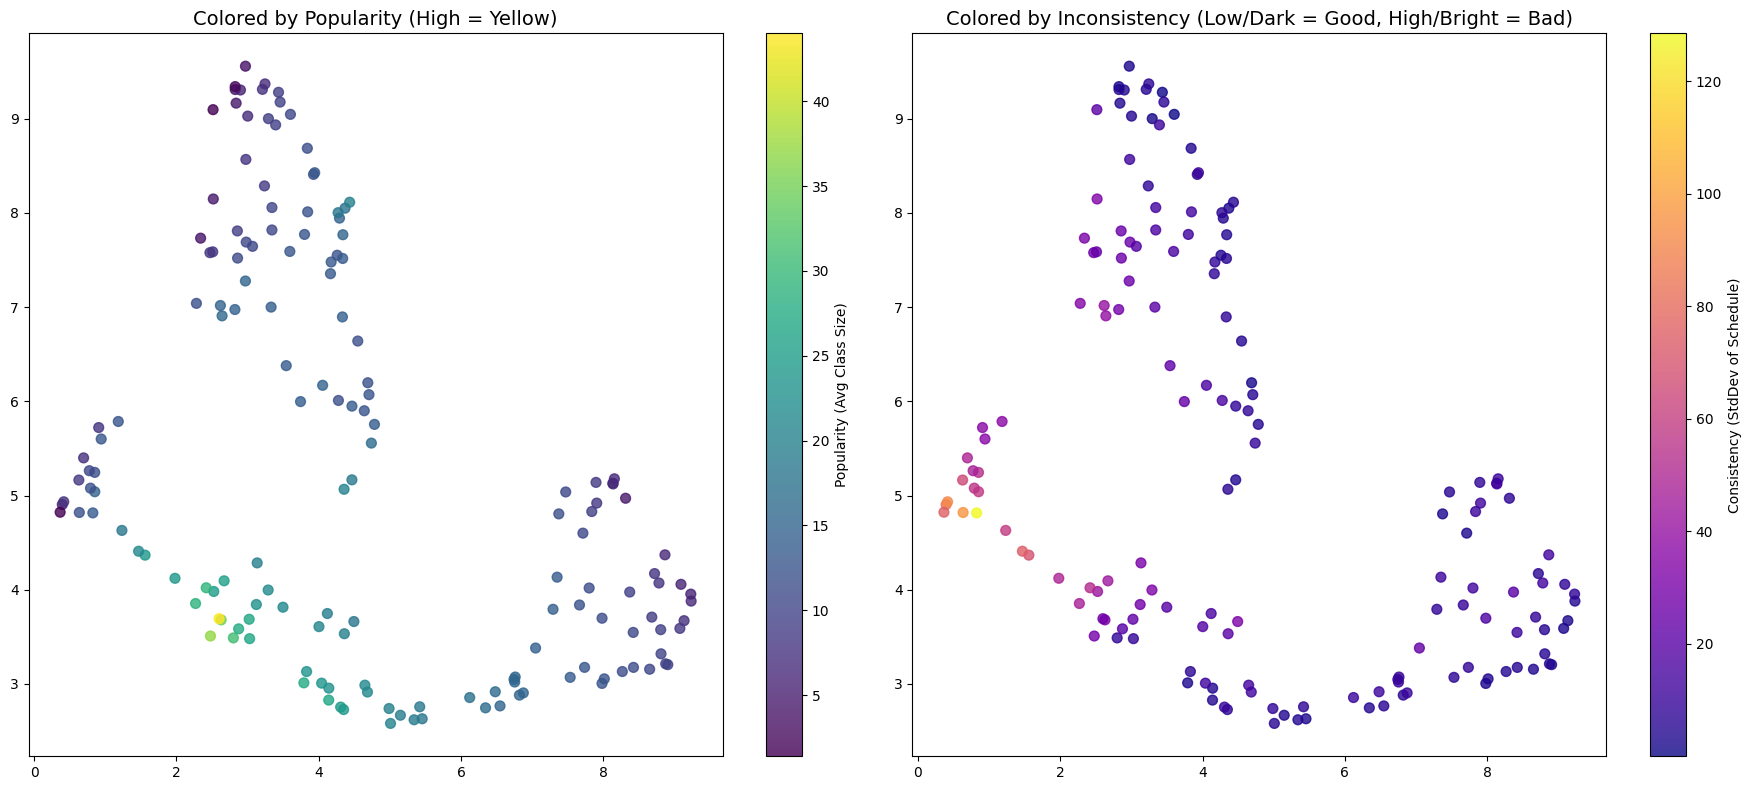

Comparison Insight: Do the 'Yellow' Popularity dots match the 'Dark' Consistency dots?
If yes, then Popular leaders are the Consistent ones.


In [33]:
# Preprocessing
features = ['consistency_std', 'tenure_days', 'popularity_avg_size']
X = df_leaders[features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run UMAP
try:
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(X_scaled)
    
    # Plot Side-by-Side
    fig, ax = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot 1: Popularity
    sc1 = ax[0].scatter(
        embedding[:, 0], embedding[:, 1], 
        c=df_leaders['popularity_avg_size'], cmap='viridis', 
        s=50, alpha=0.8
    )
    plt.colorbar(sc1, ax=ax[0], label='Popularity (Avg Class Size)')
    ax[0].set_title('Colored by Popularity (High = Yellow)', fontsize=14)
    
    # Plot 2: Consistency
    # Note: Lower Consistency StdDev is BETTER. In plot, Low = Dark Purple.
    # Reversed cmap 'magma_r' makes Low (0) Bright and High (Chaotic) Dark, or vice versa.
    # Let's use 'plasma' and standard: Dark = Low Value (High Consistency).
    sc2 = ax[1].scatter(
        embedding[:, 0], embedding[:, 1], 
        c=df_leaders['consistency_std'], cmap='plasma', 
        s=50, alpha=0.8
    )
    plt.colorbar(sc2, ax=ax[1], label='Consistency (StdDev of Schedule)')
    ax[1].set_title('Colored by Inconsistency (Low/Dark = Good, High/Bright = Bad)', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    print("Comparison Insight: Do the 'Yellow' Popularity dots match the 'Dark' Consistency dots?")
    print("If yes, then Popular leaders are the Consistent ones.")

except Exception as e:
    print(f"UMAP Visualization Failed: {e}")

C:\Users\ahmed\AppData\Local\Temp\ipykernel_27324\4195395352.py:16: UserWarning: Adding colorbar to a different Figure <Figure size 1800x800 with 6 Axes> than <Figure size 1200x500 with 0 Axes> which fig.colorbar is called on.
  plt.colorbar(sc1, ax=ax[0], label='Popularity (Avg Class Size)')


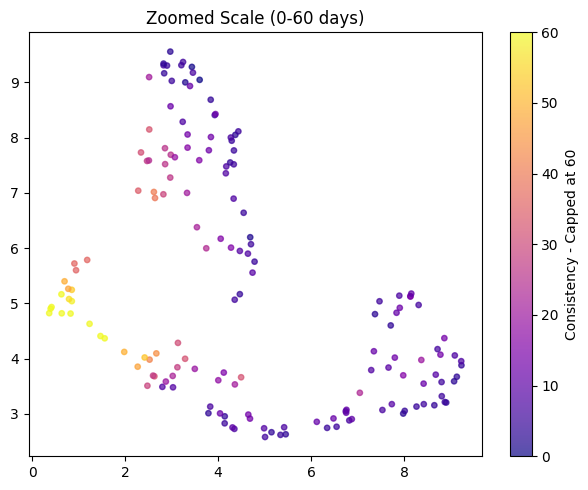

In [43]:
import matplotlib.pyplot as plt

# --- FIXED VARIABLES ---
TARGET_DF = df_leaders
EMBEDDING = embedding
# -----------------------

plt.figure(figsize=(12, 5))

# Plot 1: Popularity
sc1 = ax[0].scatter(
    embedding[:, 0], embedding[:, 1], 
    c=df_leaders['popularity_avg_size'], cmap='viridis', 
    s=50, alpha=0.8
)
plt.colorbar(sc1, ax=ax[0], label='Popularity (Avg Class Size)')
ax[0].set_title('Colored by Popularity (High = Yellow)', fontsize=14)

# Plot 2: Capped Scale (The Fix)
plt.subplot(1, 2, 2)
plt.scatter(
    EMBEDDING[:, 0], 
    EMBEDDING[:, 1], 
    c=TARGET_DF['consistency_std'], 
    cmap='plasma', 
    vmin=0, 
    vmax=60,  # <--- Cap at 60 days 
    s=15, 
    alpha=0.7
)
plt.colorbar(label='Consistency - Capped at 60')
plt.title('Zoomed Scale (0-60 days)')

plt.tight_layout()
plt.show()

## 4. Identify Dominant Leader for each User

In [35]:
event_leader_map = leaders_df[['event_id', 'user_id']].drop_duplicates('event_id')
event_leader_map.columns = ['event_id', 'leader_id']

attendance = df[['user_id', 'event_id', 'start_time']].merge(event_leader_map, on='event_id', how='left')
attendance = attendance.dropna(subset=['leader_id'])
attendance = attendance[attendance['user_id'] != attendance['leader_id']] 

# Find Dominant
ul_counts = attendance.groupby(['user_id', 'leader_id']).size().reset_index(name='count')
ul_counts.sort_values(['user_id', 'count'], ascending=[True, False], inplace=True)
dominant = ul_counts.drop_duplicates('user_id', keep='first')[['user_id', 'leader_id']]
dominant.columns = ['user_id', 'dominant_leader_id']

print(f"Identified Dominant Leader for {len(dominant)} users.")

Identified Dominant Leader for 5789 users.


## 5. Descriptive Cohort Analysis

In [36]:
user_last = df.sort_values('start_time').drop_duplicates('user_id', keep='last')[['user_id', 'start_time']]
NOW = df['start_time'].max()
user_last['churn_event'] = ((NOW - user_last['start_time']).dt.days > 90).astype(int)
user_last['is_retained'] = ((NOW - user_last['start_time']).dt.days <= 90).astype(int)

user_first = df.sort_values('start_time').drop_duplicates('user_id', keep='first')[['user_id', 'start_time', 'gender']]
user_first.rename(columns={'start_time': 'first_date'}, inplace=True)

cohorts = dominant.merge(user_last[['user_id', 'churn_event', 'is_retained']], on='user_id')
cohorts = cohorts.merge(user_first[['user_id', 'first_date', 'gender']], on='user_id')
cohorts = cohorts.merge(df_leaders, left_on='dominant_leader_id', right_index=True)

cohorts['consistency_tier'] = pd.qcut(cohorts['consistency_std'], 4, labels=["Tier 1 (Best)", "Tier 2", "Tier 3", "Tier 4 (Worst)"])
cohorts['popularity_tier'] = pd.qcut(cohorts['popularity_avg_size'], 4, labels=["Tier 4 (Smallest)", "Tier 3", "Tier 2", "Tier 1 (Largest)"])

print("--- Retention by Leader Consistency ---")
print(cohorts.groupby("consistency_tier")["is_retained"].mean().round(4))

print("\n--- Retention by Leader Popularity ---")
print(cohorts.groupby("popularity_tier")["is_retained"].mean().round(4))

--- Retention by Leader Consistency ---
consistency_tier
Tier 1 (Best)     0.2163
Tier 2            0.2419
Tier 3            0.1860
Tier 4 (Worst)    0.1735
Name: is_retained, dtype: float64

--- Retention by Leader Popularity ---
popularity_tier
Tier 4 (Smallest)    0.2050
Tier 3               0.2087
Tier 2               0.2151
Tier 1 (Largest)     0.1879
Name: is_retained, dtype: float64


C:\Users\ahmed\AppData\Local\Temp\ipykernel_27324\4026368941.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(cohorts.groupby("consistency_tier")["is_retained"].mean().round(4))
C:\Users\ahmed\AppData\Local\Temp\ipykernel_27324\4026368941.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(cohorts.groupby("popularity_tier")["is_retained"].mean().round(4))


## 6. Run Cox Proportional Hazards Model

--- Final Cox Model Results ---


<lifelines.CoxPHFitter: fitted with 5767 total observations, 1182 right-censored observations>
             duration col = 'duration'
                event col = 'churn_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 5767
number of events observed = 4585
   partial log-likelihood = -36290.60
         time fit was run = 2026-01-06 07:59:42 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
consistency_std      0.01      1.01      0.00            0.00            0.01                1.00                1.01
tenure_days         -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
popularity_avg_size  0.01      1.01      0.00            0.00            0.01                1.00                1.01
gender_1.0          -0.23      0.79      0.05           -0.34           -0.13                0.71                0.88
gender_2.0          -0.18      0.84      0.04           -0.26           -0.10                0.77                0.91

                     cmp to     z      p  -log2(p)
covariate                                         
consistency_std        0.00  6.53 <0.005     33.80
tenure_days            0.00 -7.29 <0.005     41.51
popularity_avg_size    0.00  2.18   0.03      5.11
gender_1.0             0.00 -4.37 <0.005     16.30
gender_2.0             0.00 -4.40 <0.005     16.48
---
Concordance = 0.56
Partial AIC = 72591.19
log-likelihood ratio test = 139.43 on 5 df
-log2(p) of ll-ratio test = 91.77

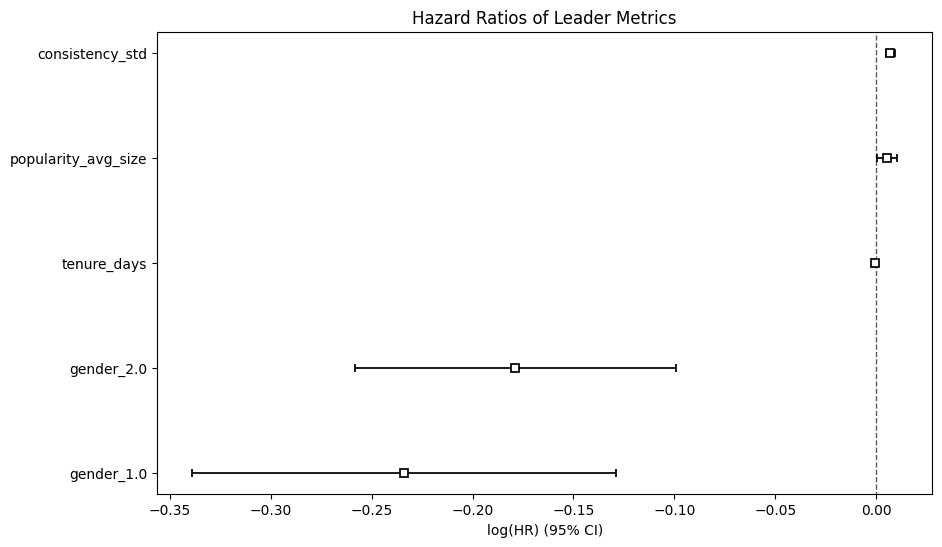

In [37]:
user_last_date = df.sort_values('start_time').drop_duplicates('user_id', keep='last')[['user_id', 'start_time']]
cohorts = cohorts.merge(user_last_date, on='user_id', suffixes=('', '_last'))
cohorts['duration'] = (cohorts['start_time'] - cohorts['first_date']).dt.days
cohorts.loc[cohorts['duration'] == 0, 'duration'] = 1

cox_df = cohorts[['duration', 'churn_event', 'consistency_std', 'tenure_days', 'popularity_avg_size', 'gender']].copy()
cox_df['gender'] = cox_df['gender'].fillna('Unknown')
cox_df = pd.get_dummies(cox_df, columns=['gender'], drop_first=True)
cox_df.columns = [c.replace(' ', '_') for c in cox_df.columns]

cph = CoxPHFitter(penalizer=0.1)
cph.fit(cox_df, duration_col='duration', event_col='churn_event')

print("--- Final Cox Model Results ---")
cph.print_summary()

plt.figure(figsize=(10,6))
cph.plot()
plt.title("Hazard Ratios of Leader Metrics")
plt.show()